In [15]:
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from sklearn.metrics import roc_curve, auc

from py.PlotUtils import get_percentiles
from py.Dataset import Dataset
from py.ImageUtils import display_images
from py.Labels import LABELS

DIR = '/home/kleinsteuber/vscode/ResizedSessions_NoBackup' # dataset directory
SESSION_NAME = "beaver_01"
CONFIGS = [
    {
        "clusters": 1024,
        "step": 20,
        "random": True,
    },
    {
        "clusters": 2048,
        "step": 20,
        "random": True,
    },
    {
        "clusters": 4096,
        "step": 20,
        "random": True,
    },
    {
        "clusters": 512,
        "random": True,
    },
    {
        "clusters": 1024,
        "random": True,
    },
    {
        "clusters": 2048,
        "random": True,
    },
    {
        "clusters": 4096,
        "random": True,
    },
    {
        "clusters": 8192,
        "random": True,
    },
    {
        "clusters": 1024,
        "step": 40,
        "random": True,
    },
    {
        "clusters": 2048,
        "step": 40,
        "random": True,
    },
    {
        "clusters": 4096,
        "step": 40,
        "random": True,
    },
]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
ds = Dataset(DIR)
session = ds.create_session(SESSION_NAME)

def read_results(clusters: int, step: int = 30, size: int = None, random: bool = False, motion: bool = False):
    # size = step by default
    if size is None:
        size = step
    
    # Get filename suffix
    suffix = ""
    if random:
        suffix += "_random"
    if motion:
        suffix += "_motion"

    # Read CSV
    test_labels = []
    test_df = []
    with open(f"./bow_train_NoBackup/{session.name}/bow_eval_{step}_{size}_{clusters}{suffix}.csv", "r") as f:
        for line in f:
            entries = line.split(",")
            # Get label
            filename = entries[0]
            img_number = int(filename[-9:-4])
            if img_number > LABELS[session.name]["max"] or img_number in LABELS[session.name]["not_annotated"]:
                continue
            is_normal = (img_number in LABELS[session.name]["normal"])
            test_labels.append(1 if is_normal else -1)
            # Get decision function values
            test_df.append([float(df) for df in entries[1:]])
    test_labels = np.array(test_labels)
    test_df = np.array(test_df)
    print(f"{len(test_df)} test results with {len(test_labels)} labels")
    return test_labels, test_df

Found 3 sessions
Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


In [17]:
def get_aucs(test_labels, test_dfs):
    aucs = []
    for i in range(test_dfs.shape[1]):
        fpr, tpr, thresholds = roc_curve(test_labels, test_dfs[:,i])
        aucs.append(auc(fpr, tpr))
    return aucs

def plot_aucs(configs, savefile=None):
    aucs_list = [get_aucs(*read_results(**config)) for config in configs]
    plt.figure(figsize=(15, 10))
    bp_dict = plt.boxplot(aucs_list, medianprops={"linewidth": 1.5, "color": "darkgoldenrod"})

    for line in bp_dict['medians']:
        # get position data for median line
        x, y = line.get_xydata()[1] # top of median line
        # overlay median value
        plt.text(x - 0.25, y + 0.0005, f"{y:.3f}", verticalalignment="bottom", horizontalalignment="center", color="darkgoldenrod") # draw above, centered

    plt.xticks(np.arange(1, len(configs) + 1), [f"k={config['clusters']},s={config['step'] if 'step' in config else 30}" for config in configs])
    plt.grid(True, ls="dotted", lw=0.5)
    # plt.ylim((0.7, 0.9))
    # plt.legend()
    if savefile is not None:
        plt.savefig(savefile, bbox_inches="tight")
    plt.show()

695 test results with 695 labels
695 test results with 695 labels
695 test results with 695 labels
695 test results with 695 labels
695 test results with 695 labels
695 test results with 695 labels
695 test results with 695 labels
695 test results with 695 labels
695 test results with 695 labels
695 test results with 695 labels
695 test results with 695 labels


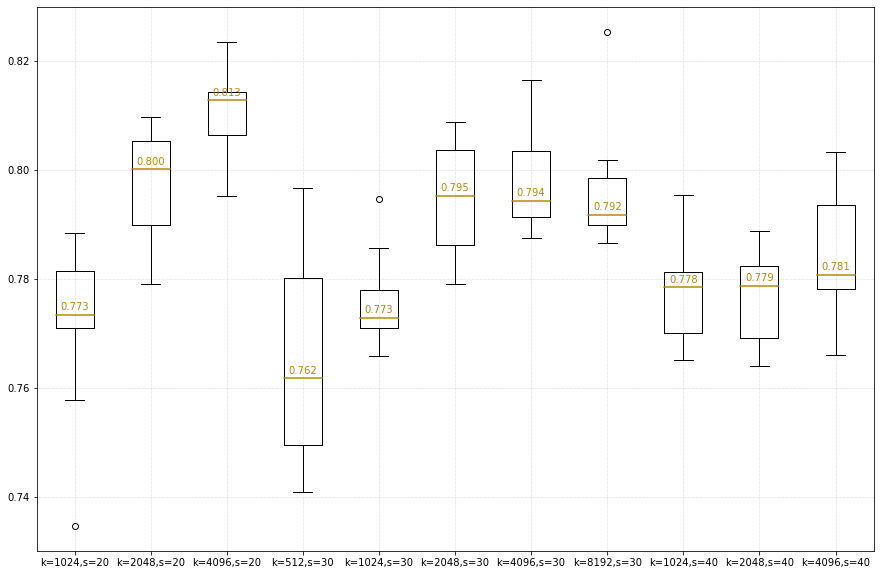

In [18]:
plot_aucs(CONFIGS, savefile="plots/approach3/boxplot_random.pdf")

In [19]:
def get_percentile_vals(test_labels, test_dfs, percentile=0.95):
    percentiles = []
    for i in range(test_dfs.shape[1]):
        fpr, tpr, thresholds = roc_curve(test_labels, test_dfs[:,i])
        percentiles.append(get_percentiles(fpr, tpr, thresholds, percentiles=[percentile], verbose = False)[0])
    return percentiles

def plot_percentiles(configs, savefile=None):
    percentiles_list = [get_percentile_vals(*read_results(**config)) for config in configs]
    plt.figure(figsize=(15, 10))
    bp_dict = plt.boxplot(percentiles_list, medianprops={"linewidth": 1.5, "color": "blue"})

    for line in bp_dict['medians']:
        # get position data for median line
        x, y = line.get_xydata()[1] # top of median line
        # overlay median value
        plt.text(x - 0.25, y + 0.0005, f"{y:.3f}", verticalalignment="bottom", horizontalalignment="center", color="blue") # draw above, centered

    plt.xticks(np.arange(1, len(configs) + 1), [f"k={config['clusters']},s={config['step'] if 'step' in config else 30}" for config in configs])
    plt.grid(True, ls="dotted", lw=0.5)
    # plt.ylim((0.7, 0.9))
    # plt.legend()
    if savefile is not None:
        plt.savefig(savefile, bbox_inches="tight")
    plt.show()

695 test results with 695 labels
695 test results with 695 labels
695 test results with 695 labels
695 test results with 695 labels
695 test results with 695 labels
695 test results with 695 labels
695 test results with 695 labels
695 test results with 695 labels
695 test results with 695 labels
695 test results with 695 labels
695 test results with 695 labels


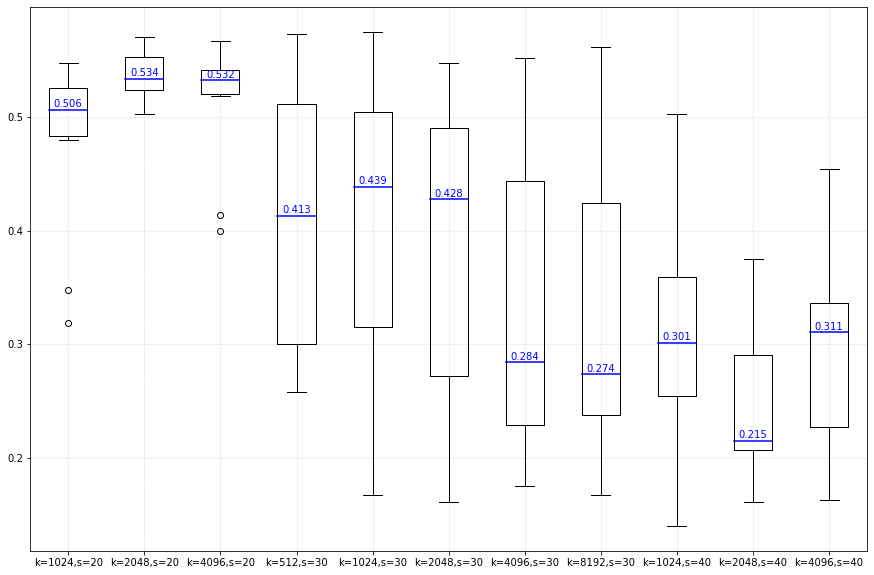

In [20]:
plot_percentiles(CONFIGS, savefile="plots/approach3/boxplot_random_tnr95.pdf")